In [83]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt

In [411]:
evaluation_path = os.path.join("..","evaluation","iresnet50_eval3.pth")
quality_path = os.path.join("..","evaluation","iresnet50_serfiq3.pth")
evaluation = torch.load(evaluation_path,map_location=torch.device('cpu') )
quality = torch.load(quality_path,map_location=torch.device('cpu') )

In [450]:
def get_roc(impostor_scores_dict: dict, pair_scores_dict: dict, number_of_points: int = 1000):
    impostor = np.array([impostor_scores_dict[key] for key in impostor_scores_dict])
    pair = np.array([pair_scores_dict[key] for key in pair_scores_dict])
    min_score = min(impostor.min(), pair.min())
    max_score = min(impostor.max(), pair.max())
    impostor_hist = np.histogram(impostor,25,density=True)
    pair_hist = np.histogram(pair,25,density=True)
    
    t_range = np.arange(min_score, max_score, (max_score - min_score)/number_of_points)
    fmr_fnmr = []
    for t in t_range:
        fmr = np.average(impostor >= t)
        fnmr = np.average(pair <= t)
        fmr_fnmr.append((fmr, fnmr))
    fmr_fnmr = np.array(fmr_fnmr)
    i = (np.abs(fmr_fnmr[:,0] - fmr_fnmr[:,1])).argmin()
    eer = t_range[i]
    return fmr_fnmr, eer, t_range, impostor_hist, pair_hist
def filter_dict_by_quality(quality_treashold: float, quality_score_dict: dict, input_dict: dict):
    filtered_pairs = filter(lambda x: (quality_score_dict[x[0]] > quality_treashold and quality_score_dict[x[0]] > quality_treashold ), input_dict )
    return dict([(x, input_dict[x]) for x in  filtered_pairs])
def get_roc_at_irr(irr: float, quality_score_sorted: np.array, quality_score_dict: dict, impostor_scores_dict: dict, pair_scores_dict: dict, number_of_points: int = 1000):
    t = quality_score_sorted[int(irr*len(quality_score_sorted))]
    filtered_impostor_scores_dict = filter_dict_by_quality(t, quality_score_dict, impostor_scores_dict)
    filtered_pair_scores_dict = filter_dict_by_quality(t, quality_score_dict, pair_scores_dict)
    return get_roc(filtered_impostor_scores_dict, filtered_pair_scores_dict)
def get_fnmr_at_irr(quality_score_dict, impostor_scores_dict: dict, pair_scores_dict: dict, number_of_points: int = 100, fmr_value = 0.01):
    quality_score = np.array([quality_score_dict[key] for key in quality_score_dict])
    quality_score_sorted = np.sort(quality_score)
    irr_fnmr = []
    for i in range(number_of_points):
        irr = i/number_of_points
        fmr_fnmr, eer, _ , _ , _ = get_roc_at_irr(irr, quality_score_sorted, quality_score_dict, impostor_scores_dict, pair_scores_dict)
        idx = (np.abs(fmr_fnmr[:,0] - fmr_value)).argmin()
        fnmr = fmr_fnmr[idx,1]
        irr_fnmr.append((irr, fnmr))
    return np.array(irr_fnmr), quality_score_sorted
def plot_performance(fmr_at_fnmr, eer, t_range, impostor_hist, pair_hist, title="Plots"):
    cm_to_inch = 1.0/2.54
    fig = plt.figure(figsize=(40*cm_to_inch, 10*cm_to_inch))
    axs = fig.subplots(1, 3)

    
    axs[0].plot(fmr_at_fnmr[:,0],fmr_at_fnmr[:,1])
    axs[0].grid(alpha=0.8, linestyle='dashdot', lw=1)
    axs[0].set_title("FNMR@FMR")
    axs[0].set_xlabel("FMR")
    axs[0].set_ylabel("FNMR")
    axs[0].set_xscale('log')
    axs[0].set_yscale('log')

    axs[1].hist(pair_hist[1][:-1], pair_hist[1], weights=pair_hist[0],alpha=0.73,label='Pair distribution')
    axs[1].hist(impostor_hist[1][:-1], impostor_hist[1], weights=impostor_hist[0],alpha=0.73,label='Impostor distribution')
    axs[1].legend()
    axs[1].set_xlabel("Distance metric")
    axs[1].set_ylabel("Probability")
    axs[1].set_title("Probability distributions")

    axs[2].plot(t_range, fmr_at_fnmr[:,0], label="FMR")
    axs[2].plot(t_range, fmr_at_fnmr[:,1], label="FNMR")
    axs[2].grid(alpha=0.8, linestyle='dashdot', lw=1)
    axs[2].legend()
    axs[2].set_title("FNMR and FMR curves at given treashold")
    axs[2].set_xlabel("Treashold")
    
    fig.tight_layout()
    fig.subplots_adjust(top=0.85)
    fig.suptitle(title,fontsize=16,fontstyle="oblique")
    plt.show()
    print(f"Equal error rate: {eer}, FNMR and fmr value: {fmr_at_fnmr[t_range == eer,0][0]}, FNMR at FMR=0.01: {fmr_at_fnmr[(np.abs(fmr_at_fnmr[:,0] - 0.01)).argmin(),1]}")
def plot_irr_fnmr(irr_fnmr, fmr=0.01):
    plt.plot(irr_fnmr[:,0],irr_fnmr[:,1])
    plt.title(f"FNMR@IRR FMR={fmr}")
    plt.xlabel("IRR")
    plt.ylabel("FNMR")
    plt.grid(alpha=0.8, linestyle='dashdot', lw=1)
    plt.show()
    print(f"Done")

In [445]:
irr_fnmr, quality_score_sorted = get_fnmr_at_irr(quality["scores"], evaluation['impostor_scores']['cosine'], evaluation['pair_scores']['cosine'], number_of_points=100, fmr_value=0.01)

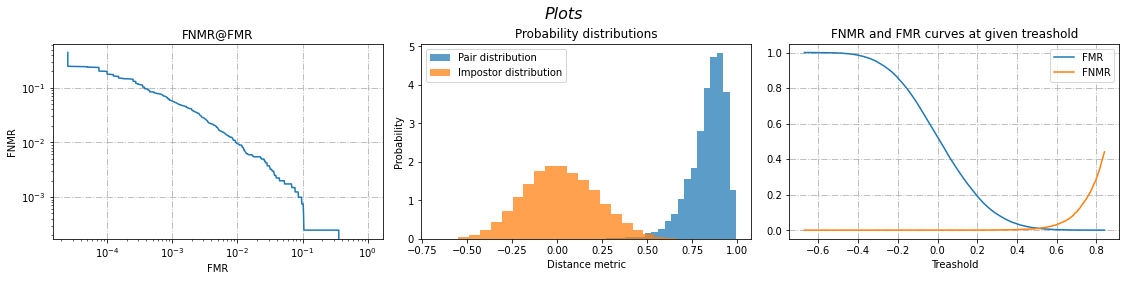

Equal error rate: 0.5111299926638229, FNMR and fmr value: 0.009704344328238133, FNMR at FMR=0.01: 0.009417596034696406


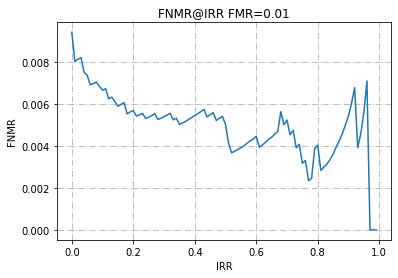

Done


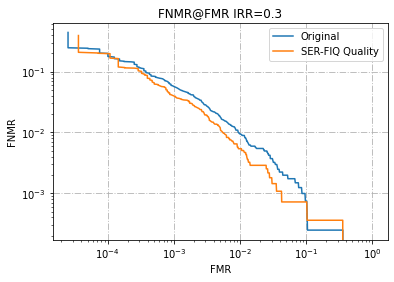

In [451]:
plot_performance(*get_roc(evaluation['impostor_scores']['cosine'], evaluation['pair_scores']['cosine']))
plot_irr_fnmr(irr_fnmr)
fmn_fnmr_o,_,_,_,_ = get_roc(evaluation['impostor_scores']['cosine'], evaluation['pair_scores']['cosine'])
fmn_fnmr_q,_,_,_,_ = get_roc_at_irr(0.3, quality_score_sorted, quality["scores"], evaluation['impostor_scores']['cosine'], evaluation['pair_scores']['cosine'])
plt.figure()
plt.plot(fmn_fnmr_o[:,0],fmn_fnmr_o[:,1], label="Original")
plt.plot(fmn_fnmr_q[:,0],fmn_fnmr_q[:,1], label="SER-FIQ Quality")
plt.legend()
plt.title(f"FNMR@FMR IRR={0.3}")
plt.xlabel("FMR")
plt.ylabel("FNMR")
plt.xscale('log')
plt.yscale('log')
plt.grid(alpha=0.8, linestyle='dashdot', lw=1)

In [437]:
print(fmn_fnmr_o.shape, fmn_fnmr_q.shape)

(1000, 2) (1000, 2)
